In [6]:
!pip install -r /content/drive/MyDrive/Dissertation/requirements.txt -qqq


from datetime import datetime
import json
import torch
import torchvision
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import os
import numpy as np
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch import argmax
from tqdm import tqdm
from PIL import Image
from matplotlib import pyplot as plt
import seaborn as sn
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, classification_report, balanced_accuracy_score
)
from torchsampler import ImbalancedDatasetSampler
import wandb
import numpy as np
from os import listdir
from os.path import join, isdir
from glob import glob
import cv2
import timeit
import timm
from sklearn.metrics import confusion_matrix
from torchvision.datasets import ImageFolder
from collections import Counter
from sklearn.utils import class_weight
# from autoaugment import ImageNetPolicy
# from autoaugment import CIFAR10Policy
# from autoaugment import SVHNPolicy
from torchvision.transforms import AutoAugment
from operator import itemgetter
import random

from torchvision.transforms.autoaugment import AutoAugmentPolicy

#changing the device to GPU rather than CPU if it is available,
# this will decrease model training time.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device {}".format(device))

torch.manual_seed(17)

Using device cuda:0


Several custom classes were made. The first, ImageResize(), resizes an image using the PIL image resizer set to the bilinear function. A custom class was generated even though Pytorch has its own resizer, as discussed in the following article, https://blog.zuru.tech/machine-learning/2021/08/09/the-dangers-behind-image-resizing there are resizing issues associated with certain libraries such as Pytorch which introduce artefacts or don't provide sufficient antialiasing in the resized images using libraries such as Pytorch.


In [7]:
class CustomImbalancedDatasetSampler(ImbalancedDatasetSampler):
    def __init__(self, dataset, callback_get_label, top_percent_keep, path_brisque_score):
        # mess with dataset
        with open(path_brisque_score, "r") as f:
            image_brisque_metrics = json.load(f)
        dataset_names = dataset.imgs
        n = int(len(image_brisque_metrics) * top_percent_keep)
        top_percent_brisque = dict(sorted(image_brisque_metrics.items(), key=itemgetter(1), reverse=True)[:n])
        top_percent_names = list(top_percent_brisque.keys())
        top_percent_names = [os.path.basename(x) for x in top_percent_names]
        
        filtered_dataset_names = []
        for img_path, label in dataset_names:
            if os.path.basename(img_path) in top_percent_names:
               filtered_dataset_names.append((img_path, label))
        
        dataset.imgs = filtered_dataset_names 
        # pass back up
        dataset.targets = [x[1] for x in dataset.imgs]
        dataset.samples = dataset.imgs
        super().__init__(dataset=dataset, callback_get_label=callback_get_label)


class ClassBasedCustomImbalancedDatasetSampler(ImbalancedDatasetSampler):
    def __init__(self, dataset, callback_get_label, top_percent_keep, path_brisque_score):
        # mess with dataset
        with open(path_brisque_score, "r") as f:
            image_brisque_metrics = json.load(f)
        dataset_names = dataset.imgs
        
        labels = []
        for key, _ in image_brisque_metrics.items():
            label = key.split("/")[-2]
            labels.append(label)

        labels = set(labels)

        class_dictionaries = []

        for label in labels:
            class_images = {}
            for key, value in image_brisque_metrics.items():
                image_label = key.split("/")[-2]
                if image_label == label:
                    class_images[key] = value
            class_dictionaries.append(class_images)
    
        final_top_percent_names = []

        for dictionary in class_dictionaries:
            n = int(len(dictionary) * top_percent_keep)
            top_percent_brisque = dict(sorted(dictionary.items(), key=itemgetter(1), reverse=True)[:n])
            top_percent_names = list(top_percent_brisque.keys())
            top_percent_names = [os.path.basename(x) for x in top_percent_names]
            final_top_percent_names.extend(top_percent_names)
  
        filtered_dataset_names = []
        for img_path, label in dataset_names:
            if os.path.basename(img_path) in final_top_percent_names:
               filtered_dataset_names.append((img_path, label))
        
        dataset.imgs = filtered_dataset_names 
        # pass back up
        dataset.targets = [x[1] for x in dataset.imgs]
        dataset.samples = dataset.imgs
        super().__init__(dataset=dataset, callback_get_label=callback_get_label)

class ClassBasedRandomImbalancedDatasetSampler(ImbalancedDatasetSampler):
    def __init__(self, dataset, callback_get_label, random_percent_keep, path_brisque_score):
        # mess with dataset
        with open(path_brisque_score, "r") as f:
            image_brisque_metrics = json.load(f)
        dataset_names = dataset.imgs
        
        labels = []
        for key, _ in image_brisque_metrics.items():
            label = key.split("/")[-2]
            labels.append(label)

        labels = set(labels)

        class_dictionaries = []

        for label in labels:
            class_images = {}
            for key, value in image_brisque_metrics.items():
                image_label = key.split("/")[-2]
                if image_label == label:
                    class_images[key] = value
            class_dictionaries.append(class_images)
    
        final_random_percent_names = []

        for dictionary in class_dictionaries:
            n = int(len(dictionary) * random_percent_keep)
            random_percent = dict(random.sample(dataset_names, k = len(dataset_names))[:n])
            random_percent_names = list(random_percent.keys())
            random_percent_names = [os.path.basename(x) for x in random_percent_names]
            final_random_percent_names.extend(random_percent_names)
  
        filtered_dataset_names = []
        for img_path, label in dataset_names:
            if os.path.basename(img_path) in final_random_percent_names:
               filtered_dataset_names.append((img_path, label))
        
        dataset.imgs = filtered_dataset_names 
        # pass back up
        dataset.targets = [x[1] for x in dataset.imgs]
        dataset.samples = dataset.imgs
        super().__init__(dataset=dataset, callback_get_label=callback_get_label)



class WorstCustomImbalancedDatasetSampler(ImbalancedDatasetSampler):
    def __init__(self, dataset, callback_get_label, top_percent_keep, path_brisque_score):
        # mess with dataset
        with open(path_brisque_score, "r") as f:
            image_brisque_metrics = json.load(f)
        dataset_names = dataset.imgs
        n = int(len(image_brisque_metrics) * top_percent_keep)
        top_percent_brisque = dict(sorted(image_brisque_metrics.items(), key=itemgetter(1), reverse=False)[:n])
        top_percent_names = list(top_percent_brisque.keys())
        
        filtered_dataset_names = []
        for img_path, label in dataset_names:
            if os.path.basename(img_path) in top_percent_names:
               filtered_dataset_names.append((img_path, label))
        
        dataset.imgs = filtered_dataset_names 
        # pass back up
        dataset.targets = [x[1] for x in dataset.imgs]
        dataset.samples = dataset.imgs
        super().__init__(dataset=dataset, callback_get_label=callback_get_label)

class RandomImbalancedDatasetSampler(ImbalancedDatasetSampler):
    def __init__(self, dataset, callback_get_label, random_percent_keep):
        # mess with dataset
        dataset_names = dataset.imgs
        n = int(len(dataset_names) * random_percent_keep)
        random_percent = dict(random.sample(dataset_names, k = len(dataset_names))[:n])
        random_percent_names = list(random_percent .keys())
        random_percent_names = [os.path.basename(x) for x in random_percent_names]
        
        filtered_dataset_names = []
        for img_path, label in dataset_names:
            if os.path.basename(img_path) in random_percent_names:
               filtered_dataset_names.append((img_path, label))
        
        dataset.imgs = filtered_dataset_names 
        # pass back up
        dataset.targets = [x[1] for x in dataset.imgs]
        dataset.samples = dataset.imgs
        super().__init__(dataset=dataset, callback_get_label=callback_get_label)

class ClassBasedWorstImbalancedDatasetSampler(ImbalancedDatasetSampler):
    def __init__(self, dataset, callback_get_label, percent_keep, path_brisque_score):
        # mess with dataset
        with open(path_brisque_score, "r") as f:
            image_brisque_metrics = json.load(f)
        dataset_names = dataset.imgs
        
        labels = []
        for key, _ in image_brisque_metrics.items():
            label = key.split("/")[-2]
            labels.append(label)

        labels = set(labels)

        class_dictionaries = []

        for label in labels:
            class_images = {}
            for key, value in image_brisque_metrics.items():
                image_label = key.split("/")[-2]
                if image_label == label:
                    class_images[key] = value
            class_dictionaries.append(class_images)
    
        final_worst_percent_names = []

        for dictionary in class_dictionaries:
            n = int(len(dictionary) * percent_keep)
            worst_percent_brisque = dict(sorted(dictionary.items(), key=itemgetter(1), reverse=False)[:n])
            worst_percent_names = list(worst_percent_brisque.keys())
            worst_percent_names = [os.path.basename(x) for x in worst_percent_names]
            final_worst_percent_names.extend(worst_percent_names)
  
        filtered_dataset_names = []
        for img_path, label in dataset_names:
            if os.path.basename(img_path) in final_worst_percent_names:
               filtered_dataset_names.append((img_path, label))
        
        dataset.imgs = filtered_dataset_names 
        # pass back up
        dataset.targets = [x[1] for x in dataset.imgs]
        dataset.samples = dataset.imgs
        super().__init__(dataset=dataset, callback_get_label=callback_get_label)

class PILtoCV2(object):

    def __call__(self, image):
        return cv2.cvtColor(
            np.array(image),
            cv2.COLOR_RGB2BGR
        )


class CV2toPIL(object):

    def __call__(self, image):
        color_coverted = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return Image.fromarray(color_coverted)


class ImageResize(object):
        """
        PIL's resize performs better than pytorch
        https://blog.zuru.tech/machine-learning/2021/08/09/the-dangers-behind-image-resizing
        """

        def __init__(self, new_h, new_w):
            self.new_h = new_h
            self.new_w = new_w

        def __call__(self, image):
            image = image.resize((self.new_w, self.new_h), resample=Image.BILINEAR)
            return image

class HairRemoval(object):
        """
        Hair removal code
        https://github.com/ThiruRJST/Melanoma_Classification 
        """

        def __call__(self, image):
            start_time = datetime.now()
            # convert image to grayScale
            grayScale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            # kernel for morphologyEx
            kernel = cv2.getStructuringElement(1, (17, 17))

            # apply MORPH_BLACKHAT to grayScale image
            blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)

            # apply thresholding to blackhat
            _, threshold = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)

            # inpaint with original image and threshold image
            final_image = cv2.inpaint(image, threshold, 1, cv2.INPAINT_TELEA)
            # print("Hair removal", (datetime.now() - start_time).total_seconds(), "seconds")
            return final_image


class ShadesOfGrey(object):
        """
        Code from https://github.com/ThiruRJST/Melanoma_Classification
        imgage (numpy array): the original image with format of (h, w, c)
        power (int): the degree of norm, 6 is used in reference paper
        gamma (float): the value of gamma correction, 2.2 is used in reference paper
        """

        def __init__(self, power=6, gamma=2.2):
            self.power = power
            self.gamma = gamma

        def __call__(self, image):
            start_time = datetime.now()
            image_dtype = image.dtype

            if self.gamma is not None:
                image = image.astype('uint8')
                look_up_table = np.ones((256, 1), dtype='uint8') * 0
                for i in range(256):
                    look_up_table[i][0] = 255 * pow(i / 255, 1 / self.gamma)
                image = cv2.LUT(image, look_up_table)

            image = image.astype('float32')
            image_power = np.power(image, self.power)
            rgb_vec = np.power(np.mean(image_power, (0, 1)), 1 / self.power)
            rgb_norm = np.sqrt(np.sum(np.power(rgb_vec, 2.0)))
            rgb_vec = rgb_vec / rgb_norm
            rgb_vec = 1 / (rgb_vec * np.sqrt(3))
            image = np.multiply(image, rgb_vec)

            # Andrew Anikin suggestion
            image = np.clip(image, a_min=0, a_max=255)
            # print("Shades of grey", (datetime.now() - start_time).total_seconds(), "seconds")
            return image.astype(image_dtype)
    
class CropBlackCircle(object):
    """
    https://stackoverflow.com/questions/61986407/crop-x-ray-image-to-remove-black-background 
    """
    def __call__(self, image):
        start_time = datetime.now()
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # threshold 
        thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
        hh, ww = thresh.shape

        # make bottom 2 rows black where they are white the full width of the image
        thresh[hh-3:hh, 0:ww] = 0

        # get bounds of white pixels
        white = np.where(thresh==255)
        xmin, ymin, xmax, ymax = np.min(white[1]), np.min(white[0]), np.max(white[1]), np.max(white[0])

        # crop the image at the bounds adding back the two blackened rows at the bottom
        crop = image[ymin:ymax+3, xmin:xmax]
        # print("Crop black circle", (datetime.now() - start_time).total_seconds(), "seconds")
        return crop

class CutOut(object):
    """Randomly mask out one or more patches from an image.
        Args:
            n_holes (int): Number of patches to cut out of each image.
            length (int): The length (in pixels) of each square patch.
        """
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        """
        Args:
            img (Tensor): Tensor image of size (C, H, W).
        Returns:
            Tensor: Image with n_holes of dimension length x length cut out of it.
        """
        #start_time = datetime.now()
        img = np.array(img)
        # print(img.shape)
        h = img.shape[0]
        w = img.shape[1]

        mask = np.ones((h, w), np.uint8)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        #mask = torch.from_numpy(mask)
        #mask = mask.expand_as(img)
        img = img * np.expand_dims(mask,axis=2)
        #print("Cut out", (datetime.now() - start_time).total_seconds(), "seconds")
        return img  

## Network generation

Five networks were created using several architectures loaded from the Pytroch library.  Within each model-specific function, the feature extraction layers have been frozen and the final classification layer unfrozen, to allow this final layer to train on our Lesion dataset.

In [8]:
def create_network_densenet():
        net = models.densenet161(pretrained=True)
        net.classifier = nn.Linear(in_features=2208, out_features=8, bias=True)

        for param in net.parameters():
                param.requires_grad = False
        for param in net.classifier.parameters():
                param.requires_grad = True

        return net


def create_network_efficientnet():
        net = models.efficientnet_b0(pretrained=True)
        net.classifier[1] = nn.Linear(in_features=1280, out_features=8, bias=True)

        for param in net.parameters():
                param.requires_grad = False
        for param in net.classifier.parameters():
                param.requires_grad = True

        return net

def create_network_mobilenet():
        net = models.mobilenet_v3_small(pretrained=True)
        net.classifier[3] = nn.Linear(in_features=1024, out_features=8, bias=True)

        for param in net.parameters():
            param.requires_grad = False
        for param in net.classifier.parameters():
            param.requires_grad = True

        return net


def create_network_resnet():
        net = models.resnet18(pretrained=True)
        net.fc = nn.Linear(in_features=512, out_features=8, bias=True)

        for param in net.parameters():
            param.requires_grad = False
        for param in net.fc.parameters():
            param.requires_grad = True

        return net


In [9]:
def run(config):  
    torch.manual_seed(17)
    BASE_PATH = '/content/drive/MyDrive/Dissertation/skin_lesion_data/skin_lesion_part_1_models/'
    now = str(datetime.now()).replace(":", "-").replace(" ", "_")
    RESULTS_PATH = os.path.join(BASE_PATH, now)
    os.makedirs(RESULTS_PATH, exist_ok=False)

    with open(os.path.join(RESULTS_PATH, "config.json"), "w") as f:
        json.dump(config, f, indent=4)

    if config.get("use_wandb"):
        # this integrates the third-party platform, Weights and Biases,
        # with this notebook.
        run = wandb.init(
            project="part_1_skin_lesion",
            entity="sarahlouise",
            config=config,
        )


    # ## Train, validation and test set
    #
    # The train, validation and test sets were loaded and transformed using the Pytorch functions and amended classes previously discussed.

    batch_size = config["batch_size"]
    Imagenet_NV = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

    print("Configuring datasets")
    trainset = ImageFolder(
        os.path.join(config.get("data_path"), 'train'),
        transform=transforms.Compose([
                                   ## v2 own inspired   
                            #           transforms.RandomVerticalFlip(0.5),
                            # transforms.RandomHorizontalFlip(0.5),
                            # transforms.RandomApply(nn.ModuleList([transforms.ColorJitter(),
                            #                                 transforms.GaussianBlur(3)]), p=0.1),
                            ## v1 Gessert Inspired 
                            # ImageResize(224,224),
                            # transforms.RandomVerticalFlip(0.5),
                            # transforms.RandomHorizontalFlip(0.5),
                            # transforms.RandomApply(
                            #     nn.ModuleList([
                            #                    transforms.ColorJitter(brightness=32. / 255.,saturation=0.5),
                            #                    transforms.RandomRotation(degrees=(0, 360)),
                                               #transforms.CenterCrop(100)
                                            #    ]), p=0.1),
                            # transforms.AutoAugment(AutoAugmentPolicy.IMAGENET),
                            ## v3 own inspired
                            transforms.RandomVerticalFlip(0.5),
                            transforms.RandomHorizontalFlip(0.5),
                            transforms.RandomApply(nn.ModuleList([transforms.RandomRotation(degrees=(0, 360))]), p=0.2),
                            ImageResize(224,224),
                            transforms.PILToTensor(),
                            transforms.ConvertImageDtype(torch.float),
                            transforms.Normalize(*Imagenet_NV),

                        ])
        )
    
    imbalanced_sampler_choice = [
        config.get("use_custom_imbalanced_sampler"),
        config.get("use_imbalanced_sampler"),
        config.get("use_RandomImbalancedDatasetSampler"),
        config.get("WorstCustomImbalancedDatasetSampler"),
        config.get("ClassBasedCustomImbalancedDatasetSampler"),
        config.get("ClassBasedRandomImbalancedDatasetSampler"),
        config.get("ClassBasedWorstImbalancedDatasetSampler"),
    ]
    if imbalanced_sampler_choice.count(True) > 1:
        raise ValueError("Pick one sampler, cant use all")


    # if config.get("use_custom_imbalanced_sampler") and config.get("use_imbalanced_sampler") and config.get("use_RandomImbalancedDatasetSampler") and config.get("WorstCustomImbalancedDatasetSampler"):
    #     raise ValueError("Pick one sampler, cant use all")

    elif config.get("use_custom_imbalanced_sampler"):
        sampler = CustomImbalancedDatasetSampler(
            dataset=trainset,
            callback_get_label=lambda x: x.targets,
            top_percent_keep=config.get("percent_keep"), 
            path_brisque_score="/content/drive/MyDrive/Dissertation/skin_lesion_data/v2_prepro_brisque_metrics.json",
        )
        shuffle = False
    elif config.get("use_imbalanced_sampler"):
        sampler = ImbalancedDatasetSampler(
            trainset,
            callback_get_label=lambda x: x.targets,
        )
        shuffle = False
    elif config.get("use_RandomImbalancedDatasetSampler"):
        sampler = RandomImbalancedDatasetSampler(
            trainset,
            callback_get_label=lambda x: x.targets,
            random_percent_keep=config.get("percent_keep"),
        )
        shuffle = False
    elif config.get("WorstCustomImbalancedDatasetSampler"):
        sampler = RandomImbalancedDatasetSampler(
            trainset,
            callback_get_label=lambda x: x.targets,
            random_percent_keep=config.get("percent_keep"),
        )
        shuffle = False
    elif config.get("ClassBasedCustomImbalancedDatasetSampler"):
        sampler = ClassBasedCustomImbalancedDatasetSampler(
            dataset=trainset,
            callback_get_label=lambda x: x.targets,
            top_percent_keep=config.get("percent_keep"), 
            path_brisque_score="/content/drive/MyDrive/Dissertation/skin_lesion_data/v2_prepro_brisque_metrics.json",
        )
        shuffle = False
    elif config.get("ClassBasedRandomImbalancedDatasetSampler"):
        sampler = ClassBasedRandomImbalancedDatasetSampler(
            trainset,
            callback_get_label=lambda x: x.targets,
            random_percent_keep=config.get("percent_keep"),
            # Only using to get class breakdown
            path_brisque_score="/content/drive/MyDrive/Dissertation/skin_lesion_data/v2_prepro_brisque_metrics.json",
        )
        shuffle=False
    elif config.get("ClassBasedWorstImbalancedDatasetSampler"):
        sampler = ClassBasedWorstImbalancedDatasetSampler(
            trainset,
            callback_get_label=lambda x: x.targets,
            percent_keep=config.get("percent_keep"),
            path_brisque_score="/content/drive/MyDrive/Dissertation/skin_lesion_data/v2_prepro_brisque_metrics.json",
        )
        shuffle = False
    else:
        sampler = None
        shuffle = True


    trainloader = torch.utils.data.DataLoader(
        trainset,
        batch_size=batch_size,
        num_workers=2,
        shuffle=shuffle,
        sampler=sampler,
    )

    valset = ImageFolder(
        os.path.join(config.get("data_path"), 'val'),
        transform=transforms.Compose([
                            # PILtoCV2(),
                            # HairRemoval(),
                            # CropBlackCircle(),
                            # ShadesOfGrey(),
                            # CV2toPIL(),
                            ImageResize(224,224),
                            transforms.PILToTensor(),
                            transforms.ConvertImageDtype(torch.float),
                            transforms.Normalize(*Imagenet_NV),
                        ]))

    valloader = torch.utils.data.DataLoader(
        valset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2
    )

    testset = ImageFolder(
        os.path.join(config.get("data_path"), 'test'),
        transform=transforms.Compose([
                                # PILtoCV2(),
                                # HairRemoval(),
                                # CropBlackCircle(),
                                # ShadesOfGrey(),
                                # CV2toPIL(),
                                ImageResize(224,224),
                                transforms.PILToTensor(),
                                transforms.ConvertImageDtype(torch.float),
                                transforms.Normalize(*Imagenet_NV),
                            ]))

    testloader = torch.utils.data.DataLoader(
        testset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2
    )
    
    classes = sorted(os.listdir(os.path.join(config.get("data_path"), 'train')))

    if config.get("use_wandb"):
        wandb.sklearn.plot_class_proportions(
            trainset.targets,
            testset.targets,
            classes
        )


    #making logical arguments from the configuration dictionary definied earlier
    model_name = config["model"]

    if model_name == "densenet":
        net = create_network_densenet()
    elif model_name == "efficientnet":
        net = create_network_efficientnet()
    elif model_name == "mobilenet":
        net = create_network_mobilenet()
    elif model_name == "resnet":
        net = create_network_resnet()
    else:
        raise ValueError("Model name not supported '{}'".format(model_name))

    print(f"Moving network to {device}")
    net = net.to(device)

    # ## Training configurations
    
    # defining the training configurations
    no_of_epochs = config["epochs"]
    
    # calculating class weights

    labels = np.array(trainset.targets)
    
    class_weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(labels),
        y=labels
    )
    class_weights = torch.tensor(
        class_weights,
        dtype=torch.float
    )

    if config.get("use_weighted_loss"):
        criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)
    else:
        criterion = nn.CrossEntropyLoss().to(device)

    optimizer = optim.Adam(
        net.parameters(),
        lr=config["lr"],
        amsgrad=config["use_amsgrad"]
    )

    if config["use_warm_restarts"]:
        scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer,
            T_0=10,
            T_mult=1,
        )
    else:
        scheduler = optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            round((len(trainset)/batch_size)*no_of_epochs)
        )


    # ##  Model training
    #
    # This section included the training for the model. The network was set to train, a mini-batch was passed through the model and then the loss was then backpropagated. Each trained model was also automatically saved.

    if config.get("use_wandb"):
        wandb.watch(net)

    if not config.get("use_pretrained"):
        print("Starting training")
        for epoch in range(no_of_epochs):  # loop over the dataset multiple times
            print("Epoch {} of {}".format(epoch+1, no_of_epochs))
            epoch_running_loss = []
            epoch_val_metric = []
            for i, data in tqdm(enumerate(trainloader, 1), total=len(trainloader)):
                current_step = (len(trainloader) * epoch) + i
                
                # get the inputs; data is a list of [inputs, labels]
                net.train()
                
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward + backward
                outputs = net(inputs)

                
                # outputs = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                loss.backward()
                optimizer.step()
                scheduler.step()

                # saving loss statistics
                loss_val = loss.item()
                if config.get("use_wandb"):
                    wandb.log(
                        {
                            "train/bce_logits_loss": loss_val,
                            "train/lr": scheduler.get_last_lr()[0],
                            "train/custom_step": (len(trainloader) * epoch) + i,
                        }
                    )

                # adding in valiation data testing
                if i % round(40*config.get("percent_keep", 1)) == 0:
                    model_name = "{name}-epoch-{epoch}-step-{step}.pth".format(
                        name=config["name"],
                        epoch=epoch,
                        step=i,
                    )
                    model_path = os.path.join(RESULTS_PATH, model_name)
                    # Commenting out to save space
                    # torch.save(net.state_dict(), model_path)

                    predicted = []
                    actual = []

                    print("Running validation")
                    net.eval()
                    with torch.no_grad():
                        for i, data in enumerate(tqdm(valloader, total=len(valloader))):
                            inputs, labels = data
                            inputs = inputs.to(device)
                            labels = labels.to(device)

                            outputs = net(inputs)
                            loss = criterion(outputs, labels)
                            if config.get("use_wandb"):
                                wandb.log({
                                    "val/loss": loss,
                                    "val/custom_step": current_step,
                                })

                            # collect the correct predictions for each class
                            actual.extend(labels.detach().cpu().numpy())
                            predicted.extend(torch.argmax(outputs, 1).detach().cpu().numpy())

                        mb_acc = accuracy_score(actual, predicted)
                        precision = precision_score(actual, predicted, average="macro", zero_division = 1)
                        recall = recall_score(actual, predicted, average="macro", zero_division = 1)
                        f1 = f1_score(actual, predicted, average="macro", zero_division = 1)
                        bal_acc = balanced_accuracy_score(actual, predicted)
                        metric_report = classification_report(
                            np.array(actual),
                            np.array(predicted),
                            output_dict=True,
                            zero_division=1,
                        )
                        metric_report = {
                            f"val_classes/{k}": v
                            for k, v in metric_report.items()
                        }
                        metric_report.update({
                            "val_classes/custom_step": current_step,
                        })

                        if config.get("use_wandb"):
                            wandb.log({
                                "val/accuracy": mb_acc,
                                "val/precision": precision,
                                "val/recall": recall,
                                "val/f1": f1,
                                "val/balanced_acc": bal_acc,
                                "val/custom_step": current_step
                            })
                            wandb.log(metric_report)



        print('Finished Training')
        # saving each trained model
        model_name = '{}-final.pth'.format(
            config["name"]
        )
        model_path = os.path.join(RESULTS_PATH, model_name)
        torch.save(net.state_dict(), model_path)

        print("Final model saved")

    # ##  Model testing
    #
    # The model was set to evaluate mode for testing. The predicted and actual results were saved, and used for generating a confusion matrix and metrics.
    #
    # A confusion matrix was generated, showing the number of true positives and negatives, and false positives and negatives. Additionally, the metrics were calculated, including the accuracy score, precision and recall. The corresponding graphs were created using Weights and Biases.


    if config.get("use_pretrained"):
        net.load_state_dict(
            torch.load(
                config.get("use_pretrained")
            )
        )

    predicted = []
    actual = []

    print("Testing model")
    # again no gradients needed
    net.eval()
    with torch.no_grad():
        for i, data in enumerate(tqdm(testloader, total=len(testloader))):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = net(inputs)
            actual.extend(labels.detach().cpu().numpy())
            predicted.extend(torch.argmax(outputs, 1).detach().cpu().numpy())

    print("Calculating performance metrics")
    model_accuracy = accuracy_score(actual, predicted)
    model_precision = precision = precision_score(actual, predicted,
                                                average="macro", zero_division = 1)
    model_recall = recall_score(actual, predicted,
                                average="macro", zero_division = 1)
    model_f1 = f1_score(actual, predicted, average="macro", zero_division = 1)
    model_bal_acc = balanced_accuracy_score(actual, predicted)
    metric_report = classification_report(
        np.array(actual),
        np.array(predicted),
        output_dict=True,
        zero_division=1,
    )
    metric_report = {
        f"test_classes/{k}": v
        for k, v in metric_report.items()
    }

    if config.get("use_wandb"):
        wandb.log({"test/accuracy": model_accuracy})
        wandb.log({"test/precision": model_precision})
        wandb.log({"test/recall": model_recall})
        wandb.log({"test/f1": model_f1})
        wandb.log({"test/bal_acc": model_bal_acc})
        wandb.sklearn.plot_confusion_matrix(actual, predicted, classes, normalize="true")
        wandb.log(metric_report)
    else:
        print("test/accuracy", model_accuracy)
        print("test/precision", model_precision)
        print("test/recall", model_recall)
        print("test/f1", model_f1)
        print("test/bal_acc", model_bal_acc)

    plot_save_path = os.path.join(RESULTS_PATH, '{}_confusion_matrix.png'.format(
        config["name"]
    ))
    print("Plotting confusion matrix in {}".format(plot_save_path))

    print("Calculating")
    conf_matrix = confusion_matrix(y_true=actual, y_pred=predicted, normalize="true")
    print("Done")
    fig =plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(1,1,1)
    ax.matshow(conf_matrix, cmap=plt.cm.Reds)


    plt.xlabel('Predictions')
    plt.ylabel('Actuals')
    plt.title('Confusion Matrix')
    plt.savefig(plot_save_path)
    # plt.show()

    if config.get("use_wandb"):
        run.finish()


Configuring datasets
Moving network to cuda:0
Starting training
Epoch 1 of 5


 38%|███▊      | 3/8 [00:10<00:17,  3.54s/it]

Running validation



 88%|████████▊ | 7/8 [00:35<00:03,  3.56s/it]

Running validation



100%|██████████| 8/8 [00:59<00:00,  7.48s/it]


Epoch 2 of 5


 38%|███▊      | 3/8 [00:09<00:16,  3.20s/it]

Running validation



 88%|████████▊ | 7/8 [00:34<00:03,  3.50s/it]

Running validation



100%|██████████| 8/8 [00:58<00:00,  7.34s/it]

Epoch 3 of 5



 38%|███▊      | 3/8 [00:09<00:15,  3.17s/it]

Running validation



 88%|████████▊ | 7/8 [00:34<00:03,  3.49s/it]

Running validation



100%|██████████| 8/8 [00:58<00:00,  7.35s/it]

Epoch 4 of 5



 38%|███▊      | 3/8 [00:09<00:16,  3.32s/it]

Running validation



 88%|████████▊ | 7/8 [00:34<00:03,  3.51s/it]

Running validation



100%|██████████| 8/8 [00:58<00:00,  7.36s/it]

Epoch 5 of 5



 38%|███▊      | 3/8 [00:09<00:15,  3.04s/it]

Running validation



 88%|████████▊ | 7/8 [00:34<00:03,  3.49s/it]

Running validation



100%|██████████| 8/8 [00:58<00:00,  7.33s/it]


Finished Training
Final model saved
Testing model


100%|██████████| 10/10 [00:23<00:00,  2.36s/it]


Calculating performance metrics
Plotting confusion matrix in /content/drive/MyDrive/Dissertation/skin_lesion_data/skin_lesion_part_1_models/2022-05-27_21-55-55.081962/densenet_confusion_matrix.png
Calculating
Done


test/accuracy,▁
test/bal_acc,▁
test/f1,▁
test/precision,▁
test/recall,▁
test_classes/accuracy,▁
train/bce_logits_loss,▃▇█▇▄▆▇▆▅▄▄▃▂▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train/custom_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/lr,██████▇▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
val/accuracy,▁▆▂▄█▇▇▇██
val/balanced_acc,▁▄▃▄▆▇▇▇██


Configuring datasets
Moving network to cuda:0
Starting training
Epoch 1 of 5


 44%|████▍     | 7/16 [00:19<00:25,  2.79s/it]

Running validation



 94%|█████████▍| 15/16 [00:52<00:02,  2.69s/it]

Running validation



100%|██████████| 16/16 [01:16<00:00,  4.80s/it]


Epoch 2 of 5


 44%|████▍     | 7/16 [00:18<00:24,  2.72s/it]

Running validation



 94%|█████████▍| 15/16 [00:52<00:02,  2.73s/it]

Running validation



100%|██████████| 16/16 [01:16<00:00,  4.78s/it]

Epoch 3 of 5



 44%|████▍     | 7/16 [00:18<00:24,  2.71s/it]

Running validation



 94%|█████████▍| 15/16 [00:51<00:02,  2.62s/it]

Running validation



100%|██████████| 16/16 [01:15<00:00,  4.73s/it]

Epoch 4 of 5



 44%|████▍     | 7/16 [00:18<00:23,  2.63s/it]

Running validation



 94%|█████████▍| 15/16 [00:51<00:02,  2.59s/it]

Running validation



100%|██████████| 16/16 [01:15<00:00,  4.69s/it]

Epoch 5 of 5



 44%|████▍     | 7/16 [00:18<00:23,  2.62s/it]

Running validation



 94%|█████████▍| 15/16 [00:51<00:02,  2.71s/it]

Running validation



100%|██████████| 16/16 [01:15<00:00,  4.74s/it]


Finished Training
Final model saved
Testing model


100%|██████████| 10/10 [00:23<00:00,  2.38s/it]


Calculating performance metrics
Plotting confusion matrix in /content/drive/MyDrive/Dissertation/skin_lesion_data/skin_lesion_part_1_models/2022-05-27_22-01-34.991237/densenet_confusion_matrix.png
Calculating
Done


test/accuracy,▁
test/bal_acc,▁
test/f1,▁
test/precision,▁
test/recall,▁
test_classes/accuracy,▁
train/bce_logits_loss,▃█▅▇▃▄▃▃▂▂▂▂▂▂▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/custom_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train/lr,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
val/accuracy,▄▁▆▇▇▇████
val/balanced_acc,▃▁▆▆▇▇▇███


Configuring datasets
Moving network to cuda:0
Starting training
Epoch 1 of 5


 46%|████▌     | 11/24 [00:27<00:34,  2.62s/it]

Running validation



 96%|█████████▌| 23/24 [01:10<00:02,  2.57s/it]

Running validation



100%|██████████| 24/24 [01:34<00:00,  3.92s/it]

Epoch 2 of 5



 46%|████▌     | 11/24 [00:27<00:33,  2.57s/it]

Running validation



 96%|█████████▌| 23/24 [01:09<00:02,  2.50s/it]

Running validation



100%|██████████| 24/24 [01:33<00:00,  3.90s/it]

Epoch 3 of 5



 46%|████▌     | 11/24 [00:26<00:33,  2.58s/it]

Running validation



 96%|█████████▌| 23/24 [01:09<00:02,  2.57s/it]

Running validation



100%|██████████| 24/24 [01:32<00:00,  3.87s/it]

Epoch 4 of 5



 46%|████▌     | 11/24 [00:27<00:35,  2.69s/it]

Running validation



 96%|█████████▌| 23/24 [01:09<00:02,  2.56s/it]

Running validation



100%|██████████| 24/24 [01:33<00:00,  3.90s/it]

Epoch 5 of 5



 46%|████▌     | 11/24 [00:27<00:34,  2.62s/it]

Running validation



 96%|█████████▌| 23/24 [01:09<00:02,  2.53s/it]

Running validation



100%|██████████| 24/24 [01:33<00:00,  3.90s/it]


Finished Training
Final model saved
Testing model


100%|██████████| 10/10 [00:23<00:00,  2.39s/it]


Calculating performance metrics
Plotting confusion matrix in /content/drive/MyDrive/Dissertation/skin_lesion_data/skin_lesion_part_1_models/2022-05-27_22-08-30.906143/densenet_confusion_matrix.png
Calculating
Done


test/accuracy,▁
test/bal_acc,▁
test/f1,▁
test/precision,▁
test/recall,▁
test_classes/accuracy,▁
train/bce_logits_loss,▄▇█▄▃▃▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/custom_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/lr,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
val/accuracy,▁▆▅▇██▇█▇▇
val/balanced_acc,▁▅▇▇█▇████


Configuring datasets
Moving network to cuda:0
Starting training
Epoch 1 of 5


 47%|████▋     | 15/32 [00:36<00:43,  2.59s/it]

Running validation



 97%|█████████▋| 31/32 [01:28<00:02,  2.58s/it]

Running validation



100%|██████████| 32/32 [01:51<00:00,  3.50s/it]

Epoch 2 of 5



 47%|████▋     | 15/32 [00:36<00:43,  2.55s/it]

Running validation



 97%|█████████▋| 31/32 [01:27<00:02,  2.52s/it]

Running validation



100%|██████████| 32/32 [01:51<00:00,  3.49s/it]

Epoch 3 of 5



 47%|████▋     | 15/32 [00:36<00:44,  2.61s/it]

Running validation



 97%|█████████▋| 31/32 [01:27<00:02,  2.53s/it]

Running validation



100%|██████████| 32/32 [01:51<00:00,  3.50s/it]

Epoch 4 of 5



 47%|████▋     | 15/32 [00:36<00:44,  2.63s/it]

Running validation



 97%|█████████▋| 31/32 [01:28<00:02,  2.51s/it]

Running validation



100%|██████████| 32/32 [01:52<00:00,  3.50s/it]

Epoch 5 of 5



 47%|████▋     | 15/32 [00:36<00:43,  2.54s/it]

Running validation



 97%|█████████▋| 31/32 [01:27<00:02,  2.52s/it]

Running validation



100%|██████████| 32/32 [01:51<00:00,  3.49s/it]


Finished Training
Final model saved
Testing model


100%|██████████| 10/10 [00:23<00:00,  2.38s/it]


Calculating performance metrics
Plotting confusion matrix in /content/drive/MyDrive/Dissertation/skin_lesion_data/skin_lesion_part_1_models/2022-05-27_22-16-55.806326/densenet_confusion_matrix.png
Calculating
Done


test/accuracy,▁
test/bal_acc,▁
test/f1,▁
test/precision,▁
test/recall,▁
test_classes/accuracy,▁
train/bce_logits_loss,█▇▅▃▃▃▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/custom_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train/lr,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
val/accuracy,▁▃█▅▇█▇███
val/balanced_acc,▁▄▇▇▇▇▇███


Configuring datasets
Moving network to cuda:0
Starting training
Epoch 1 of 5


 48%|████▊     | 19/40 [00:46<00:55,  2.62s/it]

Running validation



 98%|█████████▊| 39/40 [01:46<00:02,  2.55s/it]

Running validation



100%|██████████| 40/40 [02:10<00:00,  3.25s/it]

Epoch 2 of 5



 48%|████▊     | 19/40 [00:45<00:54,  2.58s/it]

Running validation



 98%|█████████▊| 39/40 [01:45<00:02,  2.59s/it]

Running validation



100%|██████████| 40/40 [02:09<00:00,  3.24s/it]

Epoch 3 of 5



 48%|████▊     | 19/40 [00:45<00:55,  2.62s/it]

Running validation



 98%|█████████▊| 39/40 [01:46<00:02,  2.62s/it]

Running validation



100%|██████████| 40/40 [02:10<00:00,  3.27s/it]

Epoch 4 of 5



 48%|████▊     | 19/40 [00:45<00:54,  2.61s/it]

Running validation



 98%|█████████▊| 39/40 [01:46<00:02,  2.64s/it]

Running validation



100%|██████████| 40/40 [02:10<00:00,  3.26s/it]

Epoch 5 of 5



 48%|████▊     | 19/40 [00:45<00:54,  2.61s/it]

Running validation



 98%|█████████▊| 39/40 [01:46<00:02,  2.58s/it]

Running validation



100%|██████████| 40/40 [02:10<00:00,  3.25s/it]


Finished Training
Final model saved
Testing model


100%|██████████| 10/10 [00:23<00:00,  2.39s/it]


Calculating performance metrics
Plotting confusion matrix in /content/drive/MyDrive/Dissertation/skin_lesion_data/skin_lesion_part_1_models/2022-05-27_22-26-51.658089/densenet_confusion_matrix.png
Calculating
Done


test/accuracy,▁
test/bal_acc,▁
test/f1,▁
test/precision,▁
test/recall,▁
test_classes/accuracy,▁
train/bce_logits_loss,██▄▄▃▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/custom_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/lr,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁
val/accuracy,▁▃█▇▇▇██▇▇
val/balanced_acc,▁▅▇▇█▇▇███


Configuring datasets
Moving network to cuda:0
Starting training
Epoch 1 of 5


 48%|████▊     | 23/48 [00:56<01:08,  2.72s/it]

Running validation



 98%|█████████▊| 47/48 [02:06<00:02,  2.59s/it]

Running validation



100%|██████████| 48/48 [02:30<00:00,  3.14s/it]

Epoch 2 of 5



 48%|████▊     | 23/48 [00:54<01:04,  2.59s/it]

Running validation



 98%|█████████▊| 47/48 [02:05<00:02,  2.58s/it]

Running validation



100%|██████████| 48/48 [02:29<00:00,  3.12s/it]

Epoch 3 of 5



 48%|████▊     | 23/48 [00:55<01:06,  2.66s/it]

Running validation



 98%|█████████▊| 47/48 [02:06<00:02,  2.58s/it]

Running validation



100%|██████████| 48/48 [02:30<00:00,  3.13s/it]

Epoch 4 of 5



 48%|████▊     | 23/48 [00:55<01:01,  2.47s/it]

Running validation



 98%|█████████▊| 47/48 [02:05<00:02,  2.59s/it]

Running validation



100%|██████████| 48/48 [02:29<00:00,  3.12s/it]

Epoch 5 of 5



 48%|████▊     | 23/48 [00:54<01:02,  2.50s/it]

Running validation



 98%|█████████▊| 47/48 [02:05<00:02,  2.51s/it]

Running validation



100%|██████████| 48/48 [02:29<00:00,  3.11s/it]


Finished Training
Final model saved
Testing model


100%|██████████| 10/10 [00:23<00:00,  2.40s/it]


Calculating performance metrics
Plotting confusion matrix in /content/drive/MyDrive/Dissertation/skin_lesion_data/skin_lesion_part_1_models/2022-05-27_22-38-20.647643/densenet_confusion_matrix.png
Calculating
Done


test/accuracy,▁
test/bal_acc,▁
test/f1,▁
test/precision,▁
test/recall,▁
test_classes/accuracy,▁
train/bce_logits_loss,█▆▃▂▂▂▂▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/custom_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/lr,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
val/accuracy,▁▇▇▇▆▄▆█▇▇
val/balanced_acc,▁▃▆▇▆▆▆███


Configuring datasets
Moving network to cuda:0
Starting training
Epoch 1 of 5


 48%|████▊     | 27/56 [01:05<01:16,  2.64s/it]

Running validation



 98%|█████████▊| 55/56 [02:24<00:02,  2.29s/it]

Running validation



100%|██████████| 56/56 [02:48<00:00,  3.01s/it]

Epoch 2 of 5



 48%|████▊     | 27/56 [01:05<01:19,  2.76s/it]

Running validation



 98%|█████████▊| 55/56 [02:26<00:02,  2.72s/it]

Running validation



100%|██████████| 56/56 [02:50<00:00,  3.05s/it]

Epoch 3 of 5



 48%|████▊     | 27/56 [01:05<01:15,  2.61s/it]

Running validation



 98%|█████████▊| 55/56 [02:26<00:02,  2.65s/it]

Running validation



100%|██████████| 56/56 [02:50<00:00,  3.05s/it]

Epoch 4 of 5



 48%|████▊     | 27/56 [01:04<01:18,  2.71s/it]

Running validation



 98%|█████████▊| 55/56 [02:25<00:02,  2.57s/it]

Running validation



100%|██████████| 56/56 [02:49<00:00,  3.03s/it]

Epoch 5 of 5



 48%|████▊     | 27/56 [01:05<01:15,  2.61s/it]

Running validation



 98%|█████████▊| 55/56 [02:25<00:02,  2.66s/it]

Running validation



100%|██████████| 56/56 [02:49<00:00,  3.03s/it]


Finished Training
Final model saved
Testing model


100%|██████████| 10/10 [00:24<00:00,  2.41s/it]


Calculating performance metrics
Plotting confusion matrix in /content/drive/MyDrive/Dissertation/skin_lesion_data/skin_lesion_part_1_models/2022-05-27_22-51-28.411061/densenet_confusion_matrix.png
Calculating
Done


test/accuracy,▁
test/bal_acc,▁
test/f1,▁
test/precision,▁
test/recall,▁
test_classes/accuracy,▁
train/bce_logits_loss,█▇▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/custom_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train/lr,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
val/accuracy,▁█▇▁█▇▆███
val/balanced_acc,▁▇▇▆▇▇████


Configuring datasets
Moving network to cuda:0
Starting training
Epoch 1 of 5


 48%|████▊     | 31/64 [01:17<01:30,  2.73s/it]

Running validation



 98%|█████████▊| 63/64 [02:47<00:02,  2.53s/it]

Running validation



100%|██████████| 64/64 [03:11<00:00,  2.99s/it]

Epoch 2 of 5



 48%|████▊     | 31/64 [01:16<01:29,  2.72s/it]

Running validation



 98%|█████████▊| 63/64 [02:48<00:02,  2.70s/it]

Running validation



100%|██████████| 64/64 [03:12<00:00,  3.01s/it]

Epoch 3 of 5



 48%|████▊     | 31/64 [01:16<01:30,  2.74s/it]

Running validation



 98%|█████████▊| 63/64 [02:47<00:02,  2.61s/it]

Running validation



100%|██████████| 64/64 [03:12<00:00,  3.00s/it]

Epoch 4 of 5



 48%|████▊     | 31/64 [01:17<01:32,  2.80s/it]

Running validation



 98%|█████████▊| 63/64 [02:48<00:02,  2.68s/it]

Running validation



100%|██████████| 64/64 [03:12<00:00,  3.01s/it]

Epoch 5 of 5



 48%|████▊     | 31/64 [01:17<01:32,  2.80s/it]

Running validation



 98%|█████████▊| 63/64 [02:48<00:02,  2.72s/it]

Running validation



100%|██████████| 64/64 [03:13<00:00,  3.02s/it]


Finished Training
Final model saved
Testing model


100%|██████████| 10/10 [00:24<00:00,  2.42s/it]


Calculating performance metrics
Plotting confusion matrix in /content/drive/MyDrive/Dissertation/skin_lesion_data/skin_lesion_part_1_models/2022-05-27_23-06-16.818981/densenet_confusion_matrix.png
Calculating
Done


test/accuracy,▁
test/bal_acc,▁
test/f1,▁
test/precision,▁
test/recall,▁
test_classes/accuracy,▁
train/bce_logits_loss,█▅▃▂▂▂▁▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/custom_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train/lr,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
val/accuracy,▁▁▇▅▆▇▇███
val/balanced_acc,▁▅▇▇▇▇▇███


Configuring datasets
Moving network to cuda:0
Starting training
Epoch 1 of 5


 49%|████▊     | 35/72 [01:29<01:44,  2.84s/it]

Running validation



 99%|█████████▊| 71/72 [03:12<00:02,  2.78s/it]

Running validation



100%|██████████| 72/72 [03:36<00:00,  3.01s/it]

Epoch 2 of 5



 49%|████▊     | 35/72 [01:30<01:46,  2.88s/it]

Running validation



 99%|█████████▊| 71/72 [03:14<00:02,  2.79s/it]

Running validation



100%|██████████| 72/72 [03:39<00:00,  3.04s/it]

Epoch 3 of 5



 49%|████▊     | 35/72 [01:29<01:41,  2.75s/it]

Running validation



 99%|█████████▊| 71/72 [03:13<00:02,  2.84s/it]

Running validation



100%|██████████| 72/72 [03:38<00:00,  3.03s/it]

Epoch 4 of 5



 49%|████▊     | 35/72 [01:29<01:43,  2.81s/it]

Running validation



 99%|█████████▊| 71/72 [03:13<00:02,  2.64s/it]

Running validation



100%|██████████| 72/72 [03:37<00:00,  3.03s/it]

Epoch 5 of 5



 49%|████▊     | 35/72 [01:30<01:47,  2.91s/it]

Running validation



 99%|█████████▊| 71/72 [03:15<00:02,  2.91s/it]

Running validation



100%|██████████| 72/72 [03:40<00:00,  3.06s/it]


Finished Training
Final model saved
Testing model


100%|██████████| 10/10 [00:24<00:00,  2.44s/it]


Calculating performance metrics
Plotting confusion matrix in /content/drive/MyDrive/Dissertation/skin_lesion_data/skin_lesion_part_1_models/2022-05-27_23-23-02.393905/densenet_confusion_matrix.png
Calculating
Done


test/accuracy,▁
test/bal_acc,▁
test/f1,▁
test/precision,▁
test/recall,▁
test_classes/accuracy,▁
train/bce_logits_loss,█▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/custom_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/lr,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁
val/accuracy,▂▁▂▄▅▆▆██▇
val/balanced_acc,▁▅▇▆▆▇▇██▇


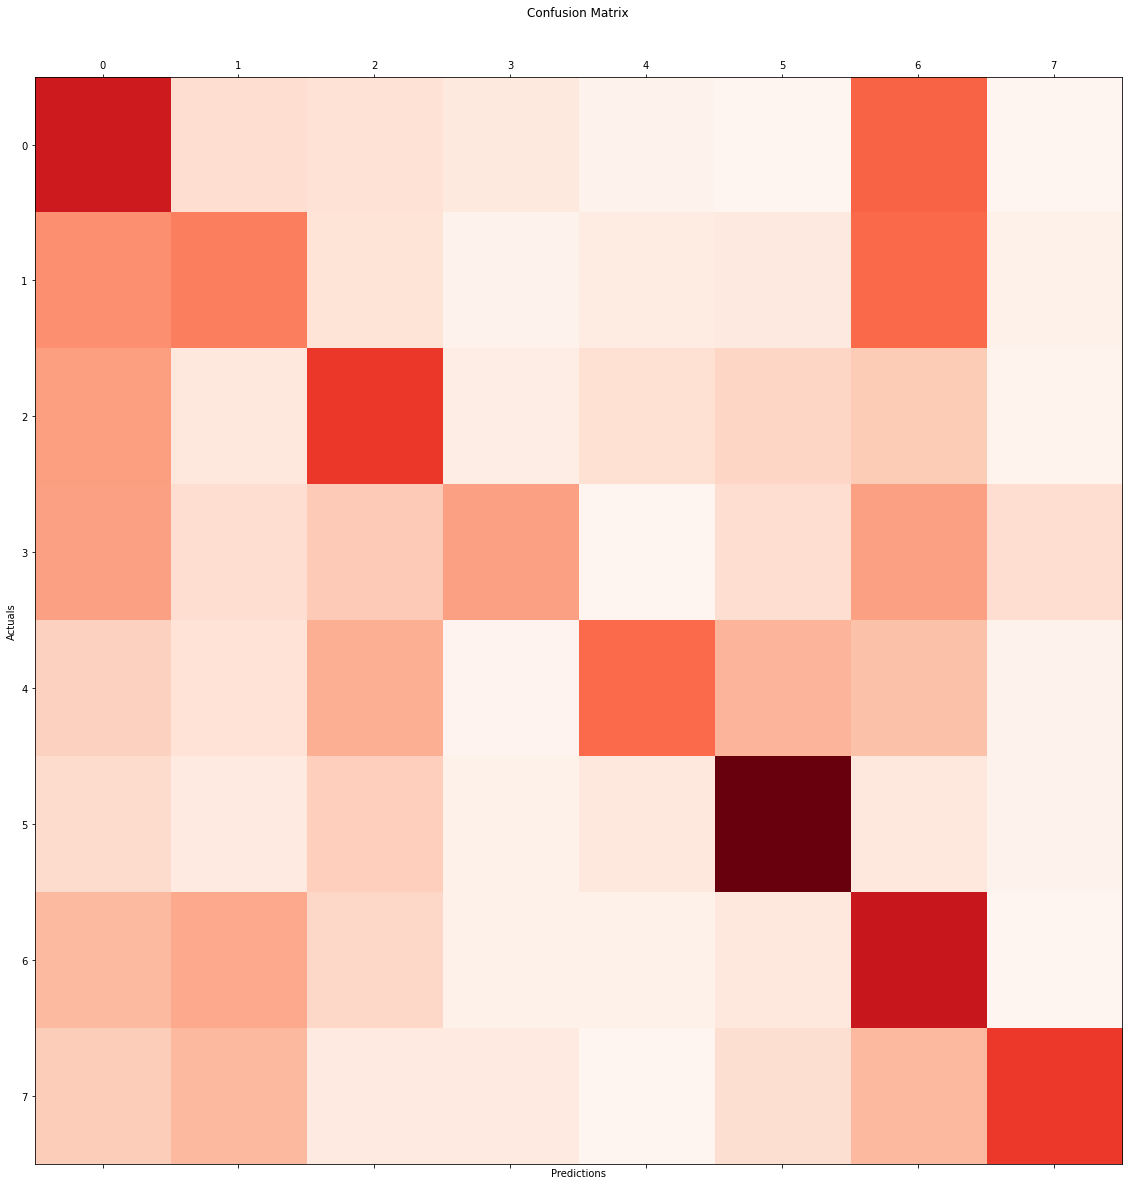

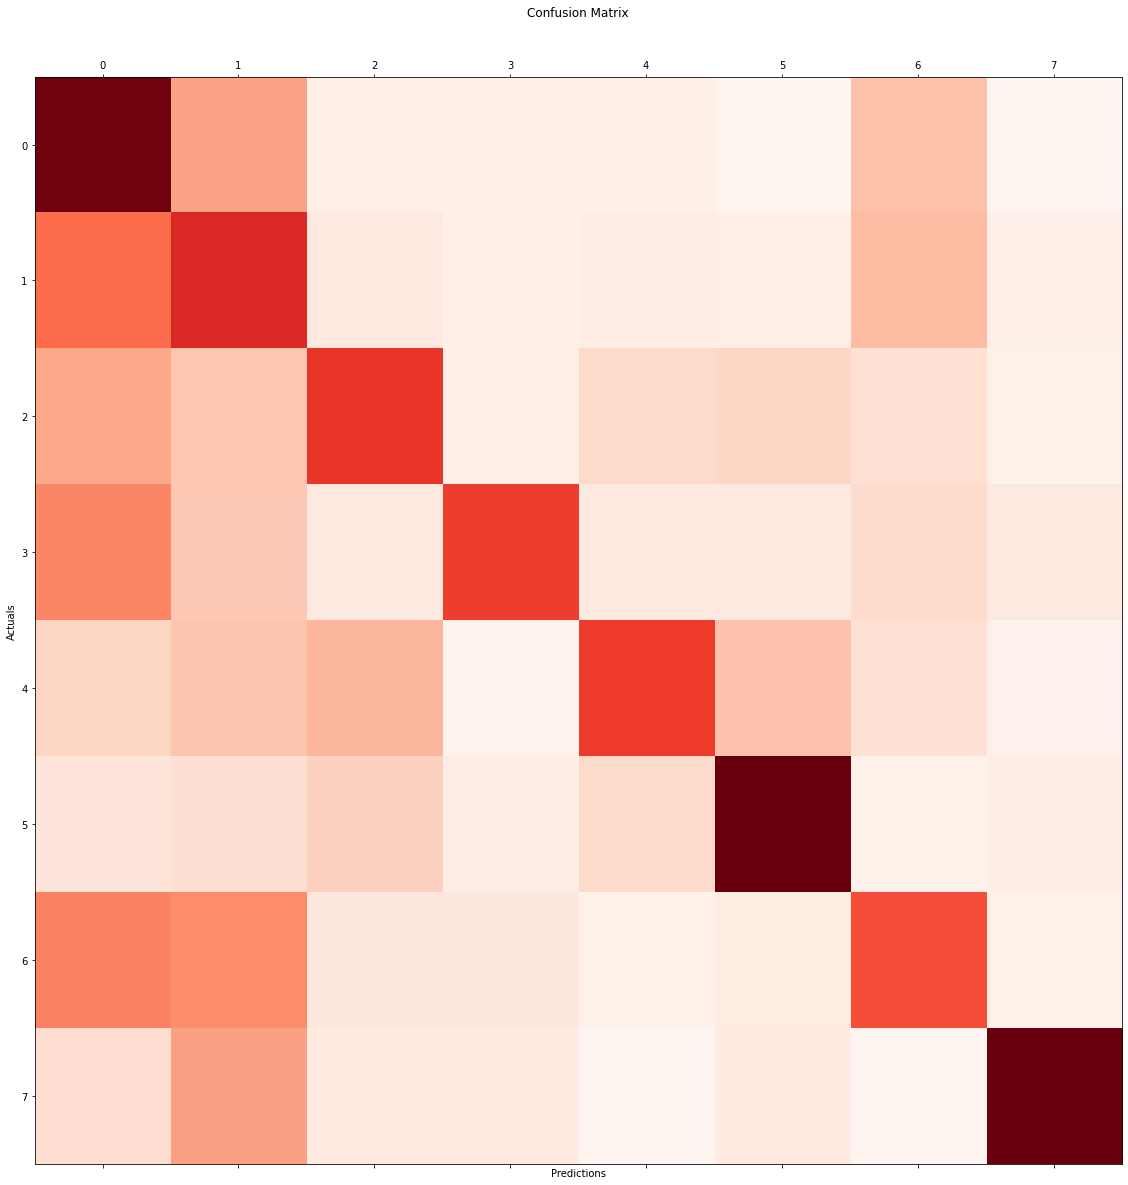

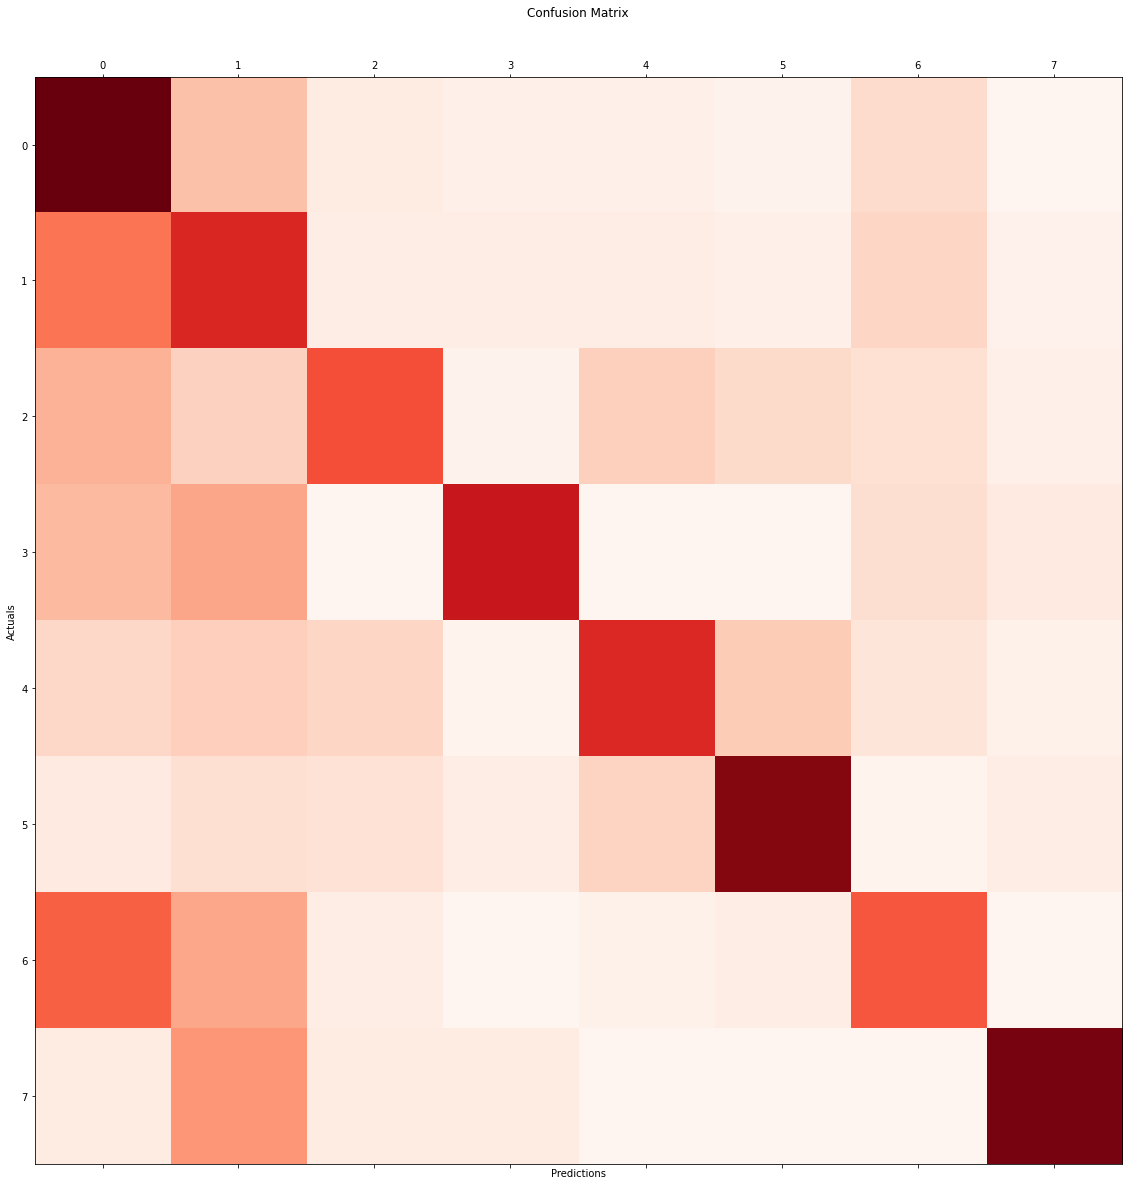

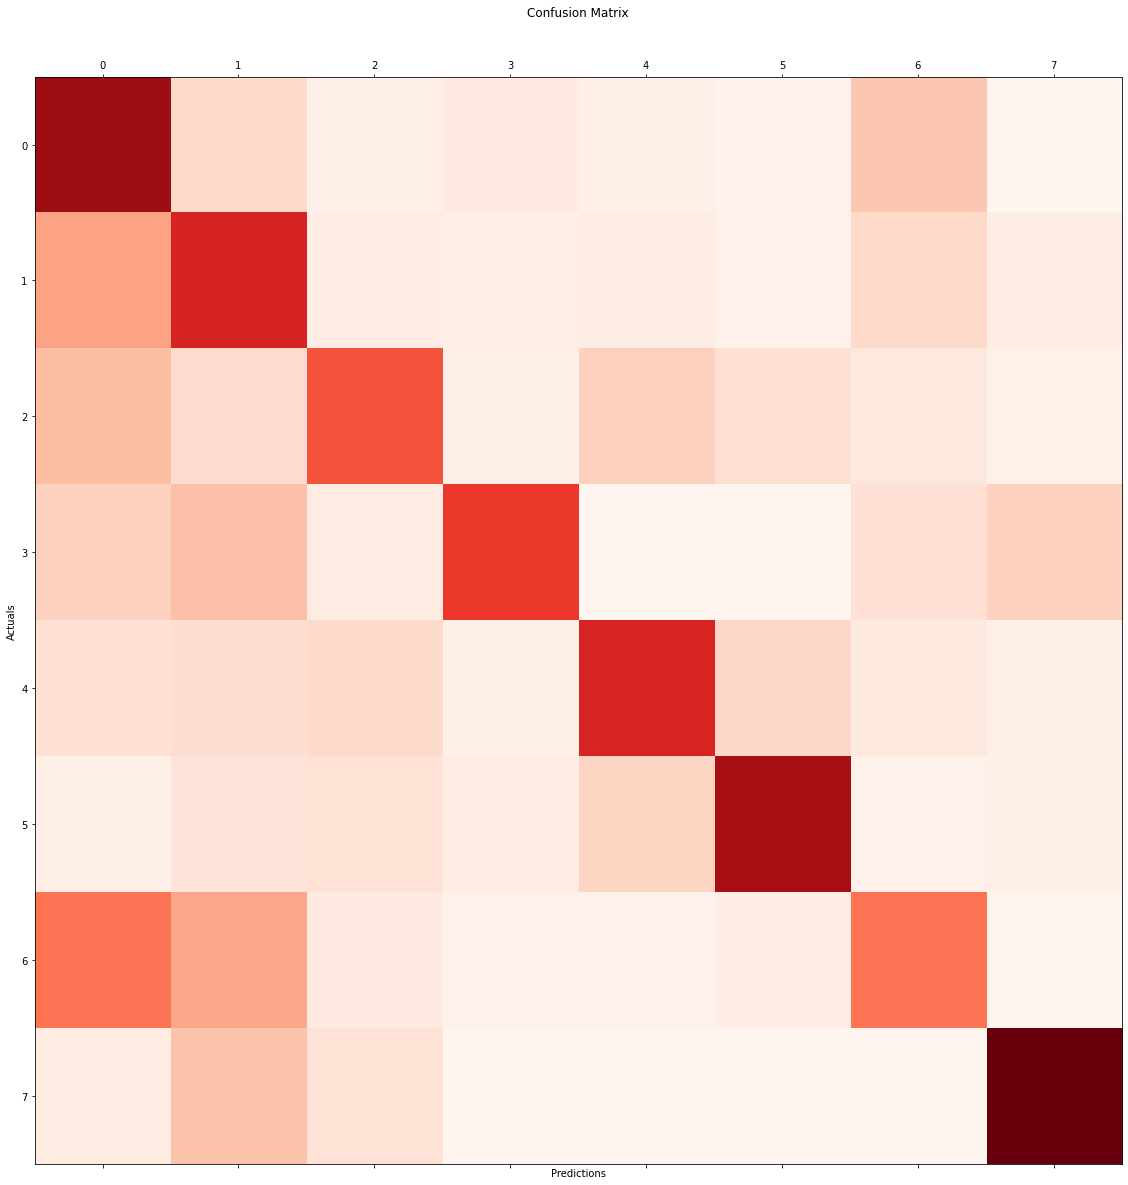

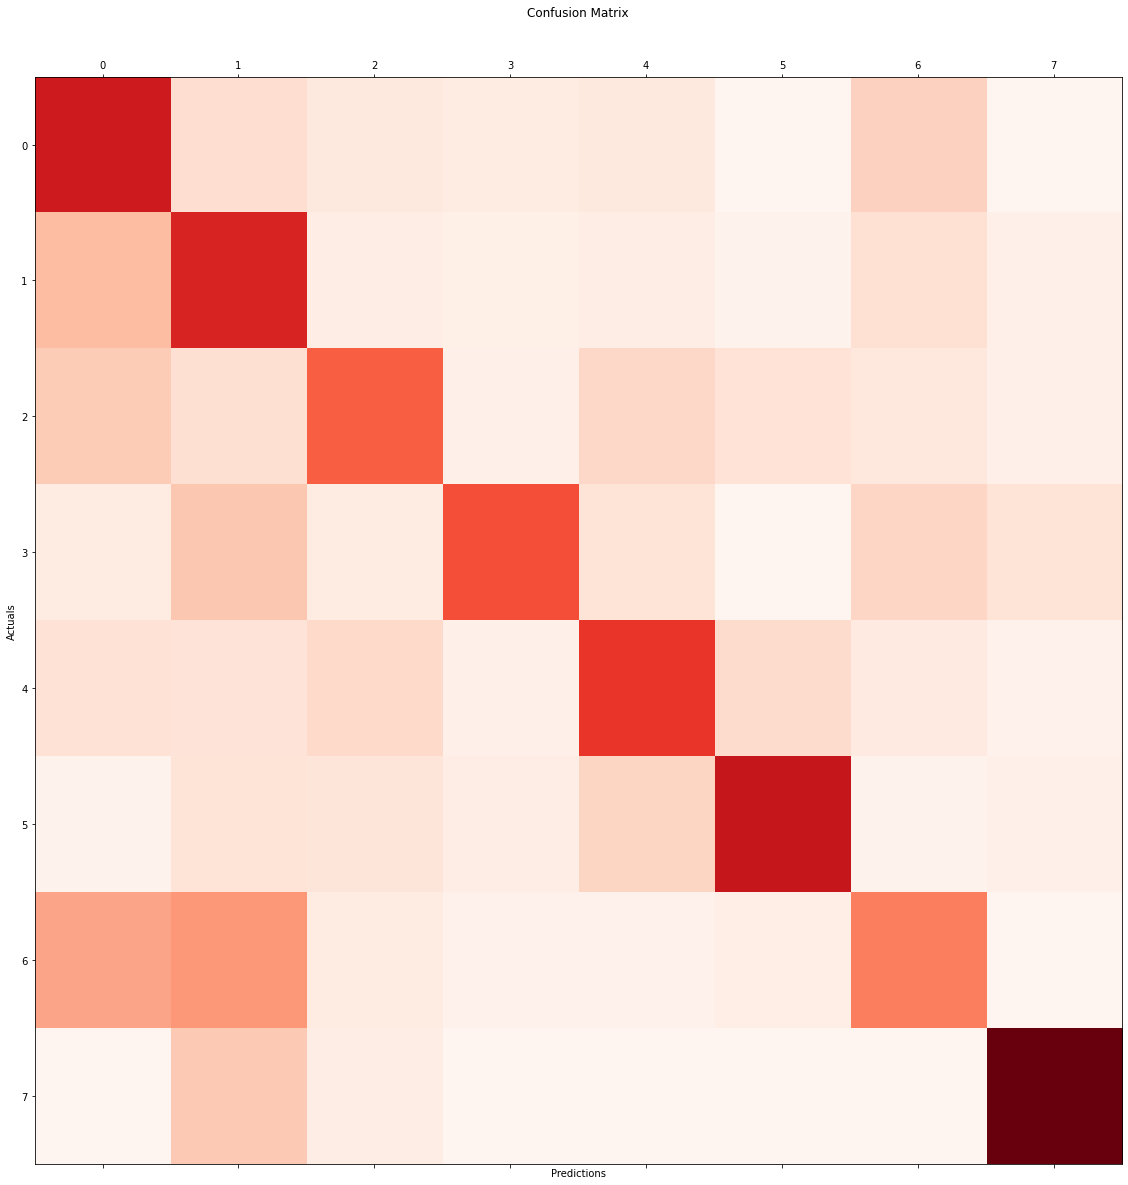

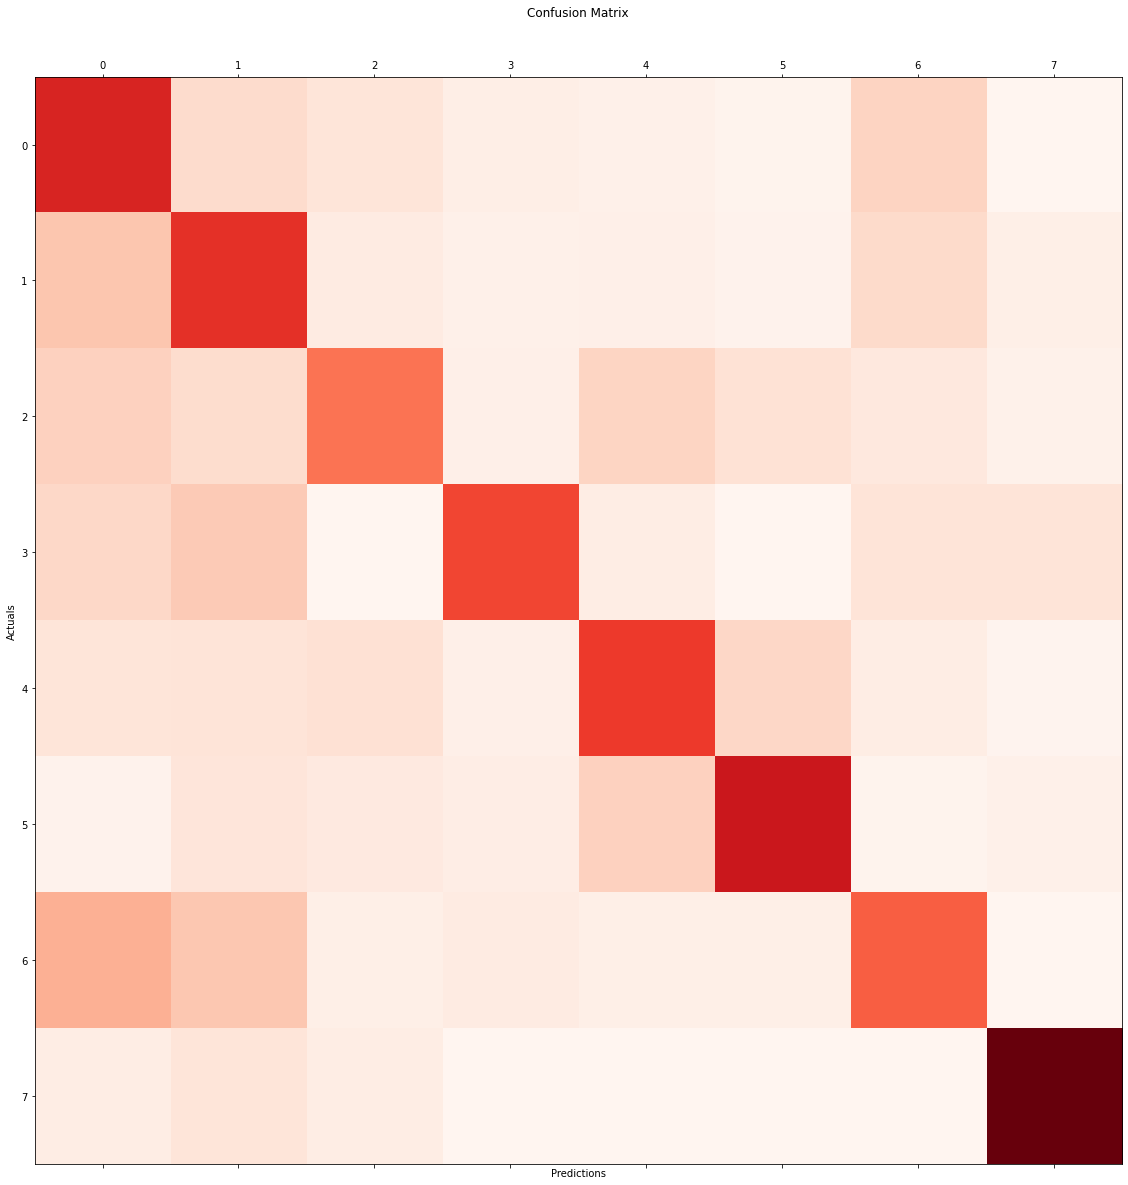

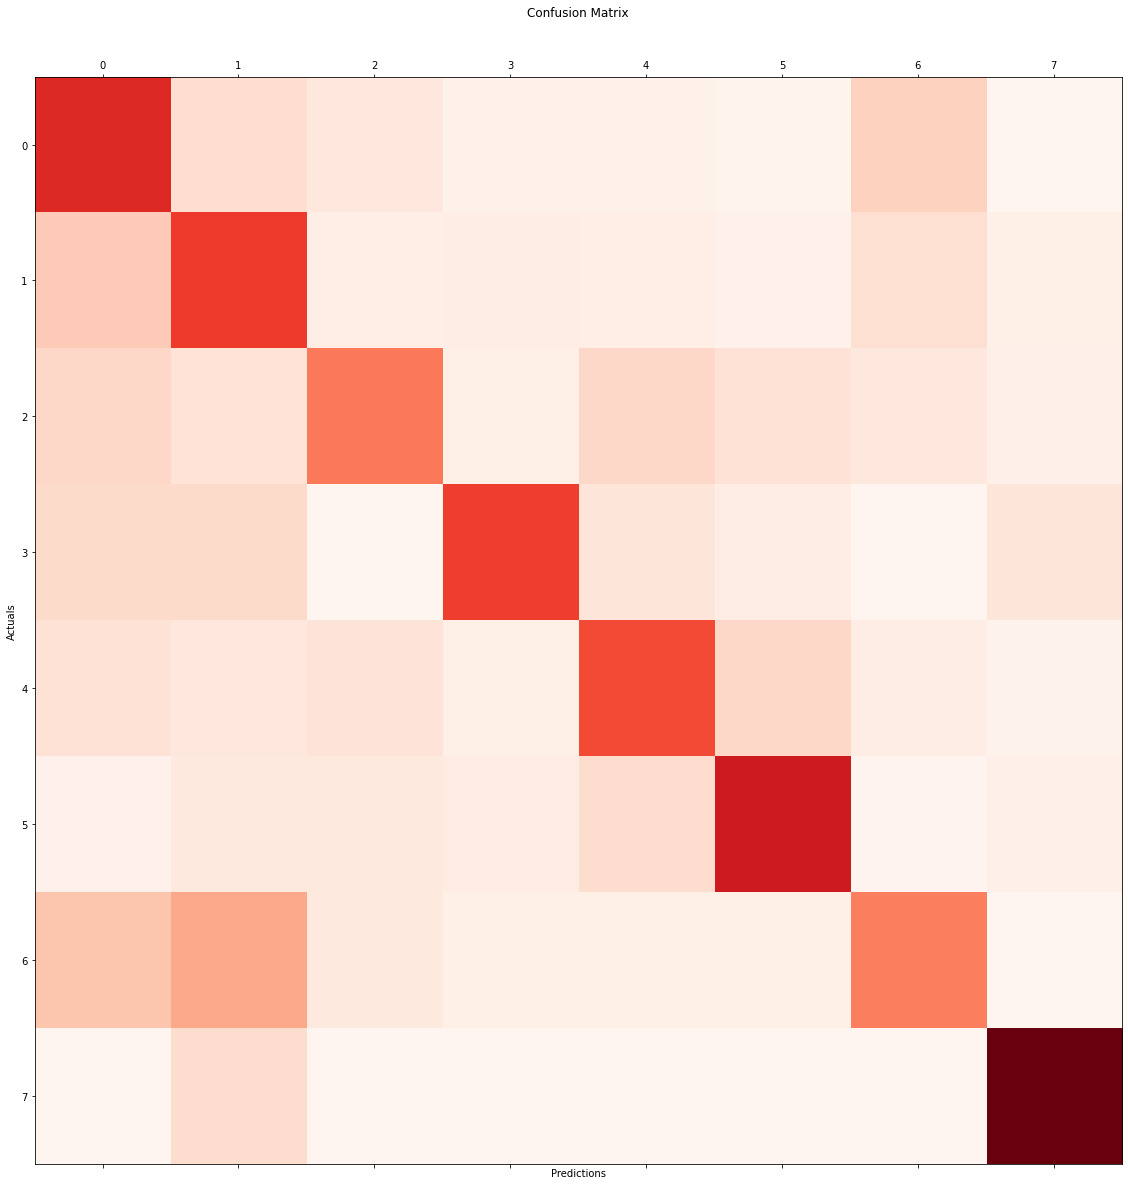

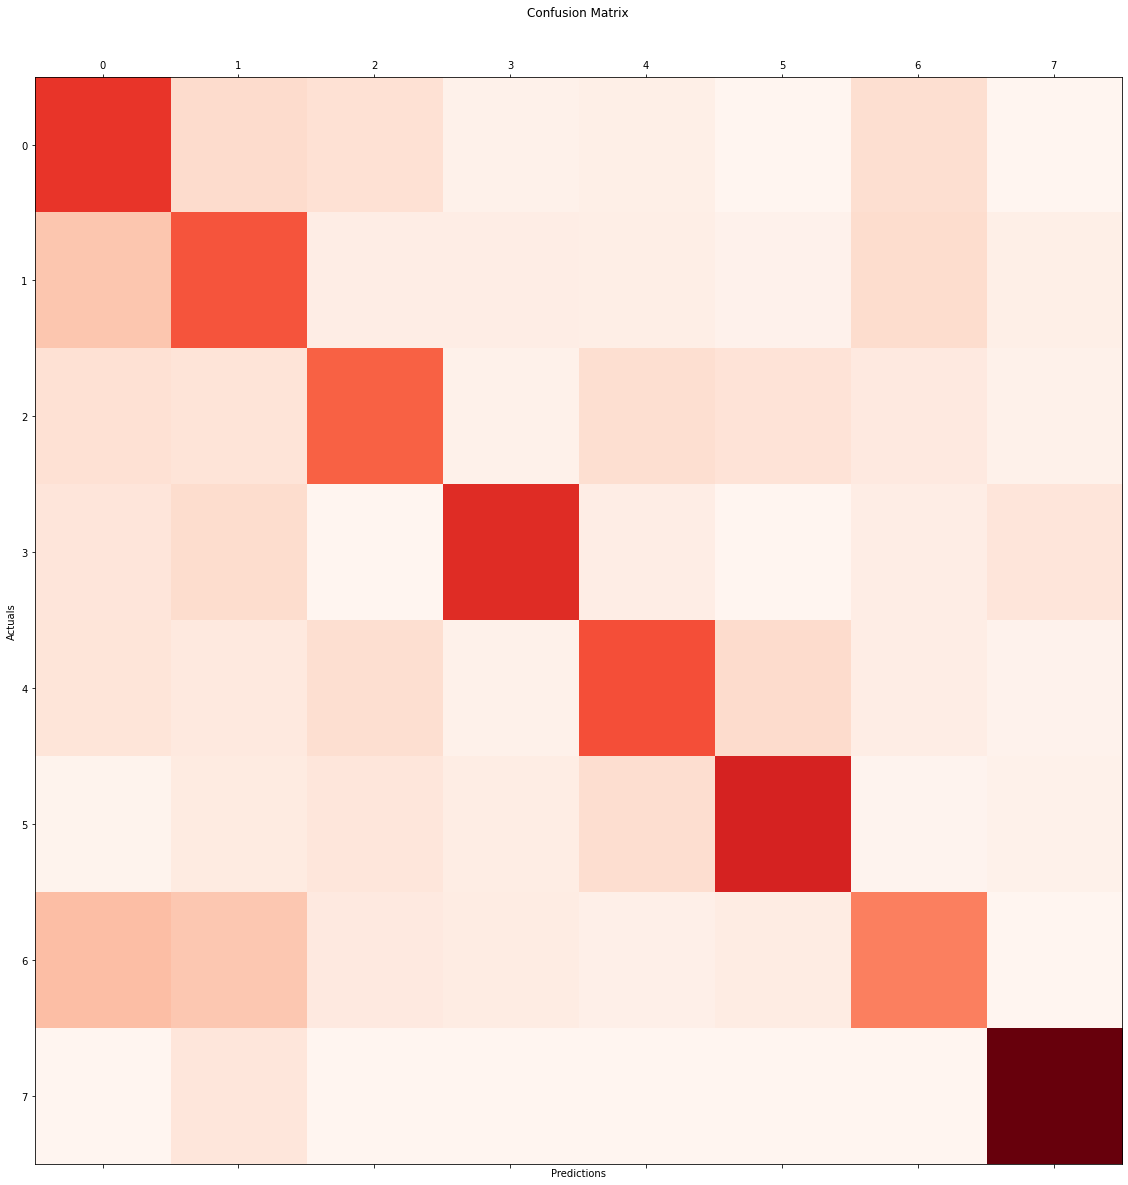

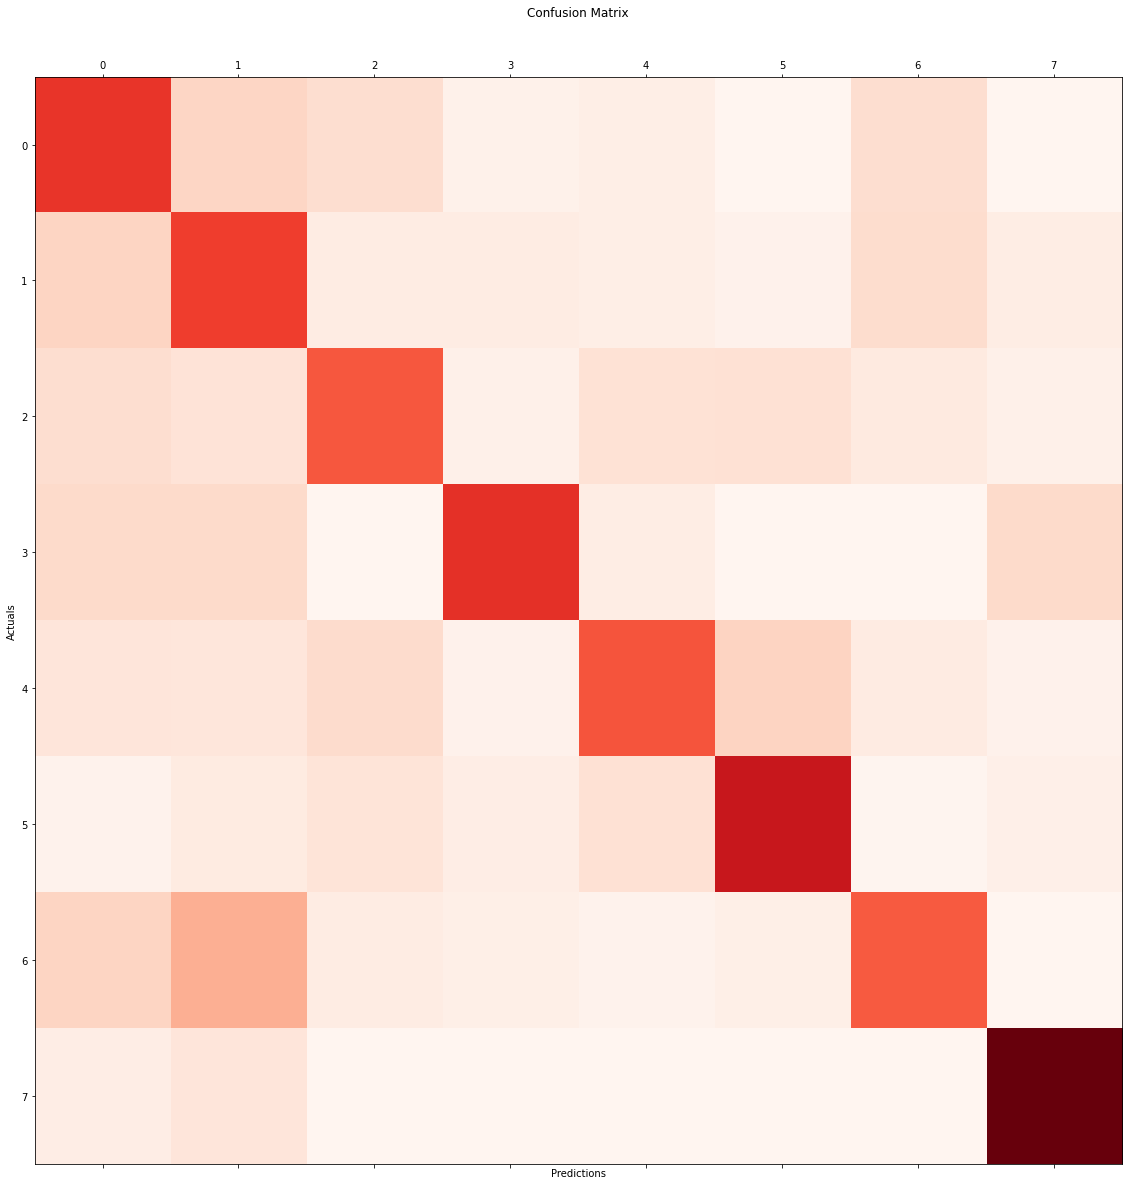

In [10]:
#from part_2 import run
percentage_intervals = np.arange(0.1, 1, 0.1).tolist()

for x in percentage_intervals:
    conf = {
        "epochs": 5,
        "batch_size": 256,
        "lr": 1e-2,
        "name": "densenet",
        "model": "densenet",
        "use_wandb": True,
        "use_amsgrad": True,
        "use_warm_restarts": False,
        "use_weighted_loss": False,
        "data_path": "/content/drive/MyDrive/Dissertation/skin_lesion_data/ISIC_2019_v2_prepro",
        "use_imbalanced_sampler": False,
        "use_custom_imbalanced_sampler": False,
        "use_RandomImbalancedDatasetSampler":False,
        "WorstCustomImbalancedDatasetSampler": False,
        "ClassBasedCustomImbalancedDatasetSampler": False,
        "ClassBasedRandomImbalancedDatasetSampler": False,
        "ClassBasedWorstImbalancedDatasetSampler": True,
        "percent_keep": round(x, 1),
        #"use_pretrained": "/content/drive/MyDrive/Dissertation/skin_lesion_data/skin_lesion_part_1_models/2022-05-17_21-00-07.965720/densenet-final.pth",
    }
    run(conf)


# all_configs = [
#             {
#         "epochs": 5,
#         "batch_size": 256,
#         "lr": 1e-2,
#         "name": "densenet",
#         "model": "densenet",
#         "use_wandb": True,
#         "use_amsgrad": True,
#         "use_warm_restarts": False,
#         "use_weighted_loss": False,
#         "data_path": "/content/drive/MyDrive/Dissertation/skin_lesion_data/ISIC_2019_v2_prepro",
#         "use_imbalanced_sampler": False,
#         "use_custom_imbalanced_sampler": True,
#         "top_percent_keep": 0.1,
#         #"use_pretrained": "/content/drive/MyDrive/Dissertation/skin_lesion_data/skin_lesion_part_1_models/2022-05-17_21-00-07.965720/densenet-final.pth",
#     },
    
# ]

# # for config in all_configs:
# #     run(config)